# Gathering data on the top 500 songs of all time from Rolling Stone Magazine

## A note on ranking things

Everyone likes ranking things, even when they don't make sense to rank. Here are some examples of things that make sense to rank:

1. **Numbers**: Literally counting 1,2,3,4,5 is a ranking system. We know that 1 is less than 2 and there is no way to suggest otherwise. Counting is the most objective ranking system I know.
2. **Largest Companies by Market Capitalization**: It is also possible to rank companies against each other so long as you have an objective metric to use. A companies Market Cap, or the price of a share multiplied by the number of shares outstanding, is a single number that can be compared to other numbers. While it is a way of determining which company is the 'biggest', it is explicit in it's criteria of evaluation. It could use a different metric to determine the company size such as Revenue, Profit, Employees, etc.. which would also be acceptable so long as they indicate that one of those is the ranking criteria. It could also use some kind of formula using multiple metrics to rank the size of companies so long as that formula was in some way sensibly derived.
3. **Highest grossing films**: Easy enough, you can order which films make the most money in an objective way

Here is something that does not make sense to rank:

- **Top Banks**: Banks could be ranked if a metric was specified. A metric was not specified here. Having worked at a bank, hearing someone talk about top X bank where 'top' is determined by.. nothing.. would be incredibly irritating. At my company last week, here was a real conversation I had on Slack:

        Marketing Person derp 1: "Hey Team! Can anyone confirm… we’ve got now 9/10 top banks?"

        Sales Person derp 2: "I heard we signed the 9th one just before the Bootcamp in December !"

        Marketing Person Derp 1: "That’s what I heard, too!!"

        Me: "Top banks by what? AUM"

        Marketing Person derp 1: "Great question. I think it's top 10 US banks"

        Me: "Sorry I mean by what metric? AUM = Assets Under Management"

        Marketing Person Derp 1: "Ohhh"

        Marketing Person Derp 1: "Another great question. Not sure. Likely by whatever metric gives us 9/10" 

Jesus christ.. 

So here's a question: What do top banks, top universities and top songs of all time have in common? They are all egregious examples of nonsense ranking systems!

## Motivation

Despite my rant about bad ranking systems, I am as guilty as anyone else about leveraging them. I used US News College Rankings as part of my decision to do my undergrad at Northwestern University, and more related to this post, I have listend extensively over the last few months to a Youtube Music playlist I made from the Rolling Stone Magazine's 2021 Top 500 songs of all time list. 

Now to be clear, I in no way endorse these rankings. I find the attempt at ranking music to be about as sensible as an attempt at ranking art or personalities, and I find this particular attempt to be pretty weak methodology-wise. And yet, the list still makes for a great playlist. I've been so into my playlist that I wanted to be more exact when I told people where certain songs ranked in the Rolling Stone top 500 list! 

Rolling Stone Magazine, however, does not make their list easily exportable, or even easily viewable on their site. Try going to it on their website: https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/. You'll see that the UI is awful, it's full of ads, and it loads slowly, especially on mobile. There needed to be a better way to see my song rankings.


### TL/DR

In this post I leverage the Beautiful Soup package in Python and the itunes API to webscrape and refine a list made by Rolling Stone Magazine in 2021 of the top 500 songs of all time.

#### Load packages

In [5]:
import pandas as pd
import numpy as np
import time

from logzero import logger

import json
import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Set URLs to visit (one for each group of 50 songs)

In [6]:
rolling_stone_headers = [
    "kanye-west-stronger-1224837",
    "neil-young-powderfinger-1224887",
    "david-bowie-station-to-station-3-1224938",
    "john-prine-angel-from-montgomery-1224988",
    "the-b-52s-rock-lobster-2-1225038",
    "jimi-hendrix-purple-haze-2-1225088",
    "david-bowie-changes-2-1225138",
    "green-day-basket-case-1225188",
    "bob-dylan-blowin-in-the-wind-3-1225238",
    "daddy-yankee-feat-glory-gasolina-1225288"
]
    
rolling_stone_links = ['https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/' + i for i in rolling_stone_headers]

#### Define functions and pulling data


In [7]:

def soupify_value(html_string):
    """ Convert String into Beautiful Soup object """ 
    return BeautifulSoup(html_string, 'html.parser')

def parse_rolling_stone(rolling_stone_links, verbose=False):
    """ Request page content for each rolling stone list """ 
    headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
    
    soup_download = []
#     return cves
    for url in rolling_stone_links:
        logger.info(f"Requesting {url}")
        req = requests.get(url, headers)
        soup = soupify_value(req.content)
        soup_download.append(soup)
        time.sleep(1)
    return soup_download

stones_data = parse_rolling_stone(rolling_stone_links)

[I 220205 13:59:41 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/kanye-west-stronger-1224837
[I 220205 13:59:44 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/neil-young-powderfinger-1224887
[I 220205 13:59:47 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/david-bowie-station-to-station-3-1224938
[I 220205 13:59:49 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/john-prine-angel-from-montgomery-1224988
[I 220205 13:59:52 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-lists/best-songs-of-all-time-1224767/the-b-52s-rock-lobster-2-1225038
[I 220205 13:59:54 <ipython-input-7-818cd49211ba>:18] Requesting https://www.rollingstone.com/music/music-list

#### Clean data and turn it into a DataFrame

In [10]:
json_artists = []
for artist_list in stones_data:
    json_artists.extend(json.loads(
        str(artist_list
         .find_all('script', attrs={'id': 'pmc-lists-front-js-extra'})[0])
         .split('pmcGalleryExports = ')[1][:-11].split(';\nvar pmcgalleryamapi')[0]
    )['gallery'])
out_dictionary = {'content': json_artists}

In [11]:
columns = ['Song Ranking', 'Song Name', 'Artist Name', 'Song Description', 'Song Image URL', 'Release Year','appleSongId']

def flag_apostrophe_bands(song):
    return "Guns N' Roses" in song['title'] or "B-52's" in song['title']

top_500_list = pd.DataFrame()
for song in out_dictionary['content']:
    song_ranking = song['positionDisplay']
    song_name = song['title'].split("'")[1] if not flag_apostrophe_bands(song) else song['title'].split(",")[1].replace("'","").strip()
    artist_name = song['title'].split("'")[0][:-2] if not flag_apostrophe_bands(song) else song['title'].split(",")[0].strip()
    description = soupify_value(song['description']).text.replace('\n', '')
    image = song['image']
    appleSongId = song['appleSongID']
    release_year = soupify_value(song['subtitle']).find('div', attrs={'class':'rs-list-item--year'}).text
    song_data = [song_ranking, song_name, artist_name, description, image, release_year, appleSongId]
    song_dict = dict(zip(columns, [[i] for i in song_data])) 
    
    top_500_list = top_500_list.append(pd.DataFrame(song_dict))
top_500_list.reset_index(drop=True, inplace=True)
    

The initial output looks pretty good!

In [12]:
top_500_list.to_csv('data/music_output.csv', index=False)

In [14]:
top_500_list.head()

,Song Ranking,Song Name,Artist Name,Song Description,Song Image URL,Release Year,appleSongId
0,500,Stronger,Kanye West,"Explaining the tighter, broader-reaching songs...",https://www.rollingstone.com/wp-content/upload...,2007,1451142309
1,499,Baby Love,The Supremes,Diana Ross wasn’t the strongest vocalist in th...,https://www.rollingstone.com/wp-content/upload...,1964,1443150938
2,498,Pancho and Lefty,Townes Van Zandt,An epic story-song about a bandit and the frie...,https://www.rollingstone.com/wp-content/upload...,1972,1182567495
3,497,Truth Hurts,Lizzo,“That song is my life and its words are my tru...,https://www.rollingstone.com/wp-content/upload...,2017,1494981961
4,496,Without You,Harry Nilsson,“We did it because my career was on the wane a...,https://www.rollingstone.com/wp-content/upload...,1971,304815013


## Add additional content

Interestingly the content we scraped right off the Rolling Stone website contains an apple song ID for each entry. My initial and mostly correct thought was that I could plug these values into the Apple Music API in order to find new content about the songs such as their genre, album, song duration and other interesting tidbits of data. 

Unfortunately, Apple requires you to have a special Developer License in order to use their API. It turns out they charge \\$99 per year which is \\$99 more than the \\$0 I was hoping to pay to get my song list. After scouring the web, I confirmed that I could not get around this charge if I wanted to leverage the Apple Music API. As a last ditch effort I tried to pipe the song id into the now deprecated itunes API. Amazingly, it worked with my test song, 'Stronger' by Kanye West.

In [13]:
apple_lookup_url = "https://itunes.apple.com/lookup?id={}"

more_song_data = requests.get(apple_lookup_url.format(top_500_list.appleSongId.to_list()[0])).json()

stronger_data = more_song_data['results'][0]
stronger_data

{'wrapperType': 'track',
 'kind': 'song',
 'artistId': 2715720,
 'collectionId': 1451142304,
 'trackId': 1451142309,
 'artistName': 'Kanye West',
 'collectionName': 'Graduation',
 'trackName': 'Stronger',
 'collectionCensoredName': 'Graduation',
 'trackCensoredName': 'Stronger',
 'artistViewUrl': 'https://music.apple.com/us/artist/kanye-west/2715720?uo=4',
 'collectionViewUrl': 'https://music.apple.com/us/album/stronger/1451142304?i=1451142309&uo=4',
 'trackViewUrl': 'https://music.apple.com/us/album/stronger/1451142304?i=1451142309&uo=4',
 'previewUrl': 'https://audio-ssl.itunes.apple.com/itunes-assets/AudioPreview125/v4/03/2a/af/032aafea-3099-991a-2d51-1f056f10020c/mzaf_6167527388584763366.plus.aac.p.m4a',
 'artworkUrl30': 'https://is2-ssl.mzstatic.com/image/thumb/Music115/v4/68/22/75/682275a2-fd3d-2b7c-ab5b-1087d2518ea9/source/30x30bb.jpg',
 'artworkUrl60': 'https://is2-ssl.mzstatic.com/image/thumb/Music115/v4/68/22/75/682275a2-fd3d-2b7c-ab5b-1087d2518ea9/source/60x60bb.jpg',
 'artw

I plugged in the song IDs for the full list and managed to extract a bunch of new data for all but 12 of them! Certainly glad Apple maintained some kind of backward compatability when they shifted over to a new music service.

In [15]:
def extract_additional_data(df):
    
    apple_lookup_url = "https://itunes.apple.com/lookup?id={}"
    columns = ['Apple Song ID', 'Album', 'Release Date', 'Explicit Flag', 'Run Time ms', 'Genre']
    additional_data_df = pd.DataFrame()
    
    for count, row in df.iterrows():
#         print(count)
        appleSongId = row['appleSongId']
        more_song_data = requests.get(apple_lookup_url.format(appleSongId)).json()
        if count / 25 == count // 25: 
            logger.info(f"Arrived at {count + 1}, song {row['Song Name']} sleeping")
            time.sleep(2)
        if len(more_song_data['results']) > 1:
            logger.warning(f"{row['Song Name']} has more than 1 result")
        try:
            stronger_data = more_song_data['results'][0]
        
            album = stronger_data['collectionName']
            releaseDate = stronger_data['releaseDate']
            song_is_explicit = stronger_data.get('contentAdvisoryRating')
            run_time_milliseconds = stronger_data['trackTimeMillis']
            genre = stronger_data['primaryGenreName']
            song_data = [[i] for i in [row['appleSongId'], album, releaseDate, song_is_explicit, run_time_milliseconds, genre]]
            additional_data_df = additional_data_df.append(pd.DataFrame(dict(zip(columns, song_data))))
        except: 
            logger.warning(f"{apple_lookup_url.format(appleSongId)} {row['Song Name']} by {row['Artist Name']} has no data :( Skipping")
    return additional_data_df
more_data = extract_additional_data(top_500_list)

[I 220205 14:14:09 <ipython-input-15-1f169afd68db>:12] Arrived at 1, song Stronger sleeping
[I 220205 14:14:15 <ipython-input-15-1f169afd68db>:12] Arrived at 26, song Rhythm Nation sleeping
[I 220205 14:14:22 <ipython-input-15-1f169afd68db>:12] Arrived at 51, song Powderfinger sleeping
[I 220205 14:14:28 <ipython-input-15-1f169afd68db>:12] Arrived at 76, song Mannish Boy sleeping
[I 220205 14:14:35 <ipython-input-15-1f169afd68db>:12] Arrived at 101, song Station to Station sleeping
[W 220205 14:14:38 <ipython-input-15-1f169afd68db>:27] https://itunes.apple.com/lookup?id=1288169541 Planet Rock by Afrika Bambaataa and the Soulsonic Force has no data :( Skipping
[I 220205 14:14:42 <ipython-input-15-1f169afd68db>:12] Arrived at 126, song Up on the Roof sleeping
[I 220205 14:14:48 <ipython-input-15-1f169afd68db>:12] Arrived at 151, song Angel From Montgomery sleeping
[W 220205 14:14:51 <ipython-input-15-1f169afd68db>:27] https://itunes.apple.com/lookup?id=1529518695 Dynamite by BTS has no d

#### Merege in New Data

In [16]:
final_list = top_500_list.merge(
    more_data, 
    left_on='appleSongId', 
    right_on = 'Apple Song ID', 
    how='left'
).drop(columns = 'Apple Song ID')
final_list['Release Date'] = pd.to_datetime(final_list['Release Date']).dt.date

In [17]:
final_list.to_csv('data/rolling_stone_top_500_output_final.csv', index=False)

In [18]:
def triple_quote_string(string):
    return f"""{string}"""

final_list['Song Description'] = final_list['Song Description'].apply(triple_quote_string)

### Quick Check on Results

In [22]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [20]:
vis_data = (
    top_500_list
    .assign(
        rev_song = lambda x: 501 - x['Song Ranking'],
        release_year = lambda x: x['Release Year'].astype(int)
    )
    .sort_values(by='Release Year')
)

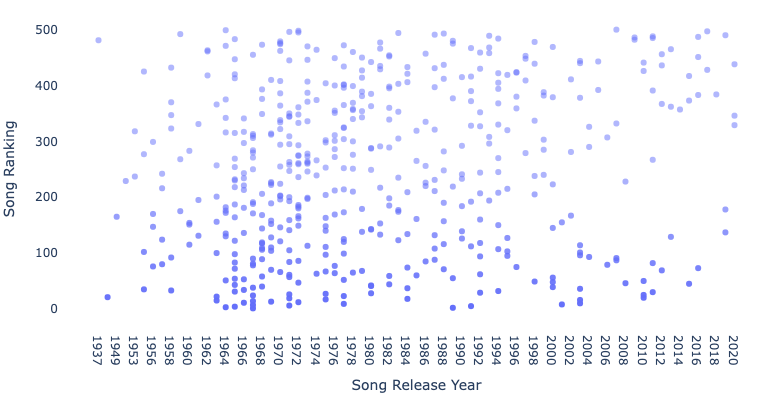

In [35]:
fig = px.scatter(
    data_frame=vis_data, 
    x='Release Year', 
    y='Song Ranking',
    opacity = np.max([1 - vis_data['Song Ranking']/500, np.repeat(.5, len(vis_data))], axis=0),
    hover_name='Song Name',
    hover_data=['Artist Name', 'Song Ranking']
)
fig = fig.update_layout(
    plot_bgcolor="white", 
    margin=dict(t=10, l=10, b=10, r=10),
    xaxis_title='Song Release Year',
    yaxis_title="Song Ranking",
    width = 800, height = 400
)
fig

Yup, this is about what I expected to see. Great Success! A lot of analysis can and should be done on this list, but my girlfriend wants me to help her clean up the house and my little brother told me he wanted to build some kind of dashboard with this. So look out for a dashboard I'll embed here soon!